# Cat Breed Identification AI Training

## Summary

The goal of this notebook is to train use different ML models that will work together to identifiy the breed of a cat based on a picture.

1. A model that can recognize if a picute is of a cat or not and automatically crop a picture of the cat.

2. A multi-class classification model that can recognize a cat's breed

## Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing import image
import tensorflow_hub as hub
import tf_keras
from tf_keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

# Object Detection Layer

I will use YOLOv8 to crop the image of the cat that will be fed into the cat breed detection model. This is to reduce noise from the image and allow for more accurate predictions

## Importing YOLOv8

In [23]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 63.2 MB/s eta 0:00:00


In [24]:
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## Load a Pre-trained YOLOv8 Model

In [25]:
yolo_model = YOLO('yolov8m.pt')

## Filter for Cats and Crop Image

In [18]:
def get_cropped_cat(image_path, yolo_model):
  image = cv2.imread(image_path)
  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  results = yolo_model(image_rgb)

  CAT_CLASS_ID = 15
  cropped_cats = []

  for result in results:
    boxes = result.boxes
    for box in boxes:
        cls_id = int(box.cls[0].item())
        if cls_id == CAT_CLASS_ID:
            x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
            cropped_cat = image_rgb[y1:y2, x1:x2]
            tf_cat = tf.convert_to_tensor(cropped_cat, dtype=tf.float32) / 255.0
            tf_cat = tf.image.resize(tf_cat, (224, 224))
            cropped_cats.append(tf_cat)

  if len(cropped_cats) == 0:
    print("No cats detected in the image.")
    return None

  return cropped_cats

In [19]:
def show_example_cropping(image_path, yolo_model):
  # Show the example image before cropping
  image = Image.open(image_path)
  plt.imshow(image)
  plt.axis('off')
  plt.show()

  # Get YOLOv8's results
  example_results = get_cropped_cat(image_path, yolo_model)

  # Show the cropped cat
  if example_results is not None:
    cropped_cat = example_results[0]
    plt.imshow(cropped_cat)
    plt.axis('off')
    plt.show()

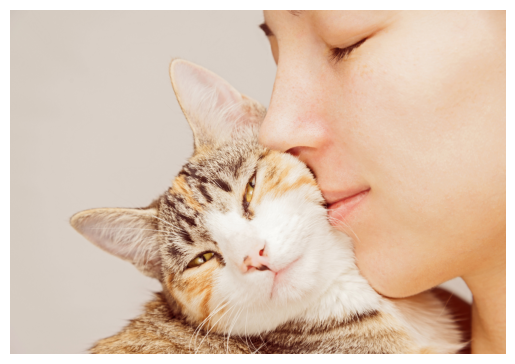


0: 448x640 1 cat, 95.8ms
Speed: 15.1ms preprocess, 95.8ms inference, 459.4ms postprocess per image at shape (1, 3, 448, 640)


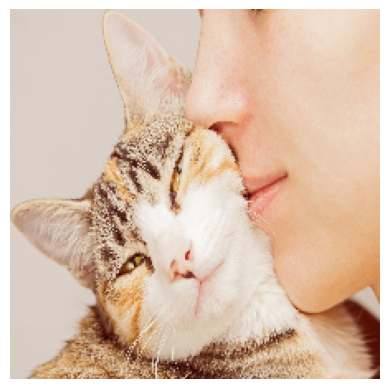

In [26]:
show_example_cropping("/content/drive/MyDrive/Cat Breed Classification/Cat Images/cat and person.jpg", yolo_model)

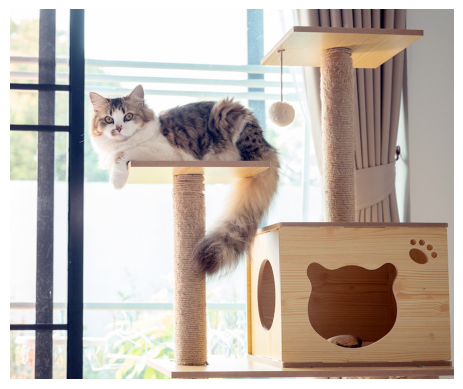


0: 544x640 1 cat, 1 microwave, 73.2ms
Speed: 3.7ms preprocess, 73.2ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 640)


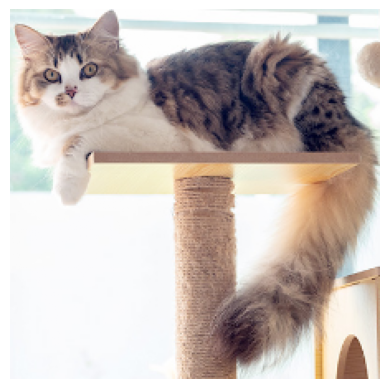

In [27]:
show_example_cropping("/content/drive/MyDrive/Cat Breed Classification/Cat Images/cat-on-tree.jpg", yolo_model)

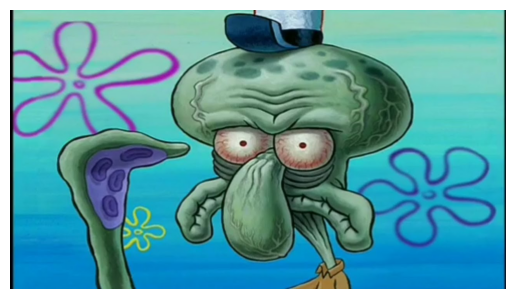


0: 384x640 1 cake, 88.0ms
Speed: 2.2ms preprocess, 88.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
No cats detected in the image.


In [28]:
show_example_cropping("/content/drive/MyDrive/Cat Breed Classification/Cat Images/squidward.jpg", yolo_model)

Looks like the cropping and object detection is working! It zooms into the cat if one is in the image, otherwise it says if it cannot find one like in the image of Squidward. This will help in giving the LLM more material about the cat's surroundings to work with and get rid of background image noise when detecting the cat's breed.

# Cat Breed Detection

I will now focus on training the cat breed classififier. Due to the small training size of images, I will be using a pretrained architecture (MobileNetV3) and use augmentation to supplement the more limited dataset of images.

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing import image
import tensorflow_hub as hub
import tf_keras
from tf_keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from tqdm import tqdm
from tensorflow.keras.optimizers import Adam

## Importing Cat Breed Data

In [6]:
def extract_breed_dataset(filepath):
    train_ds = image_dataset_from_directory(
        filepath,
        labels='inferred',
        label_mode='int',
        image_size=(224, 224),
        batch_size=32,
        color_mode='rgb',
        validation_split=0.2,
        seed=123,
        subset='training'
    )

    val_ds = image_dataset_from_directory(
        filepath,
        labels='inferred',
        label_mode='int',
        image_size=(224, 224),
        batch_size=32,
        color_mode='rgb',
        validation_split=0.2,
        seed=123,
        subset='validation'
    )

    return train_ds, val_ds

In [ ]:
cat_breed_data = "/content/drive/MyDrive/Cat App/Model 2: Cat Breed/Data"

breed_train, breed_val = extract_breed_dataset(cat_breed_data)

Found 77383 files belonging to 54 classes.
Using 61907 files for training.
Found 77383 files belonging to 54 classes.
Using 15476 files for validation.


In [ ]:
# Verify class names imported correctly

class_names = breed_train.class_names
class_names

Lets take a look at the training data's distribution.

In [ ]:
def plot_breed_distribution(dataset_path, top_n=None):
    breed_counts = {}

    for breed in os.listdir(dataset_path):
        breed_folder = os.path.join(dataset_path, breed)
        if os.path.isdir(breed_folder):
            num_images = len([
                f for f in os.listdir(breed_folder)
                if f.lower().endswith(('.jpg', '.jpeg', '.png'))
            ])
            breed_counts[breed] = num_images

    sorted_counts = sorted(breed_counts.items(), key=lambda x: x[1], reverse=True)

    if top_n:
        sorted_counts = sorted_counts[:top_n]

    breeds, counts = zip(*sorted_counts)

    plt.figure(figsize=(10, len(breeds) * 0.4))
    bars = plt.barh(breeds, counts, color='skyblue')
    plt.title("Number of Images per Cat Breed")
    plt.xlabel("Image Count")
    plt.ylabel("Breed")

    for bar in bars:
        width = bar.get_width()
        plt.text(width + 3, bar.get_y() + bar.get_height()/2, str(width),
                 va='center')

    plt.tight_layout()
    plt.gca().invert_yaxis()
    plt.show()

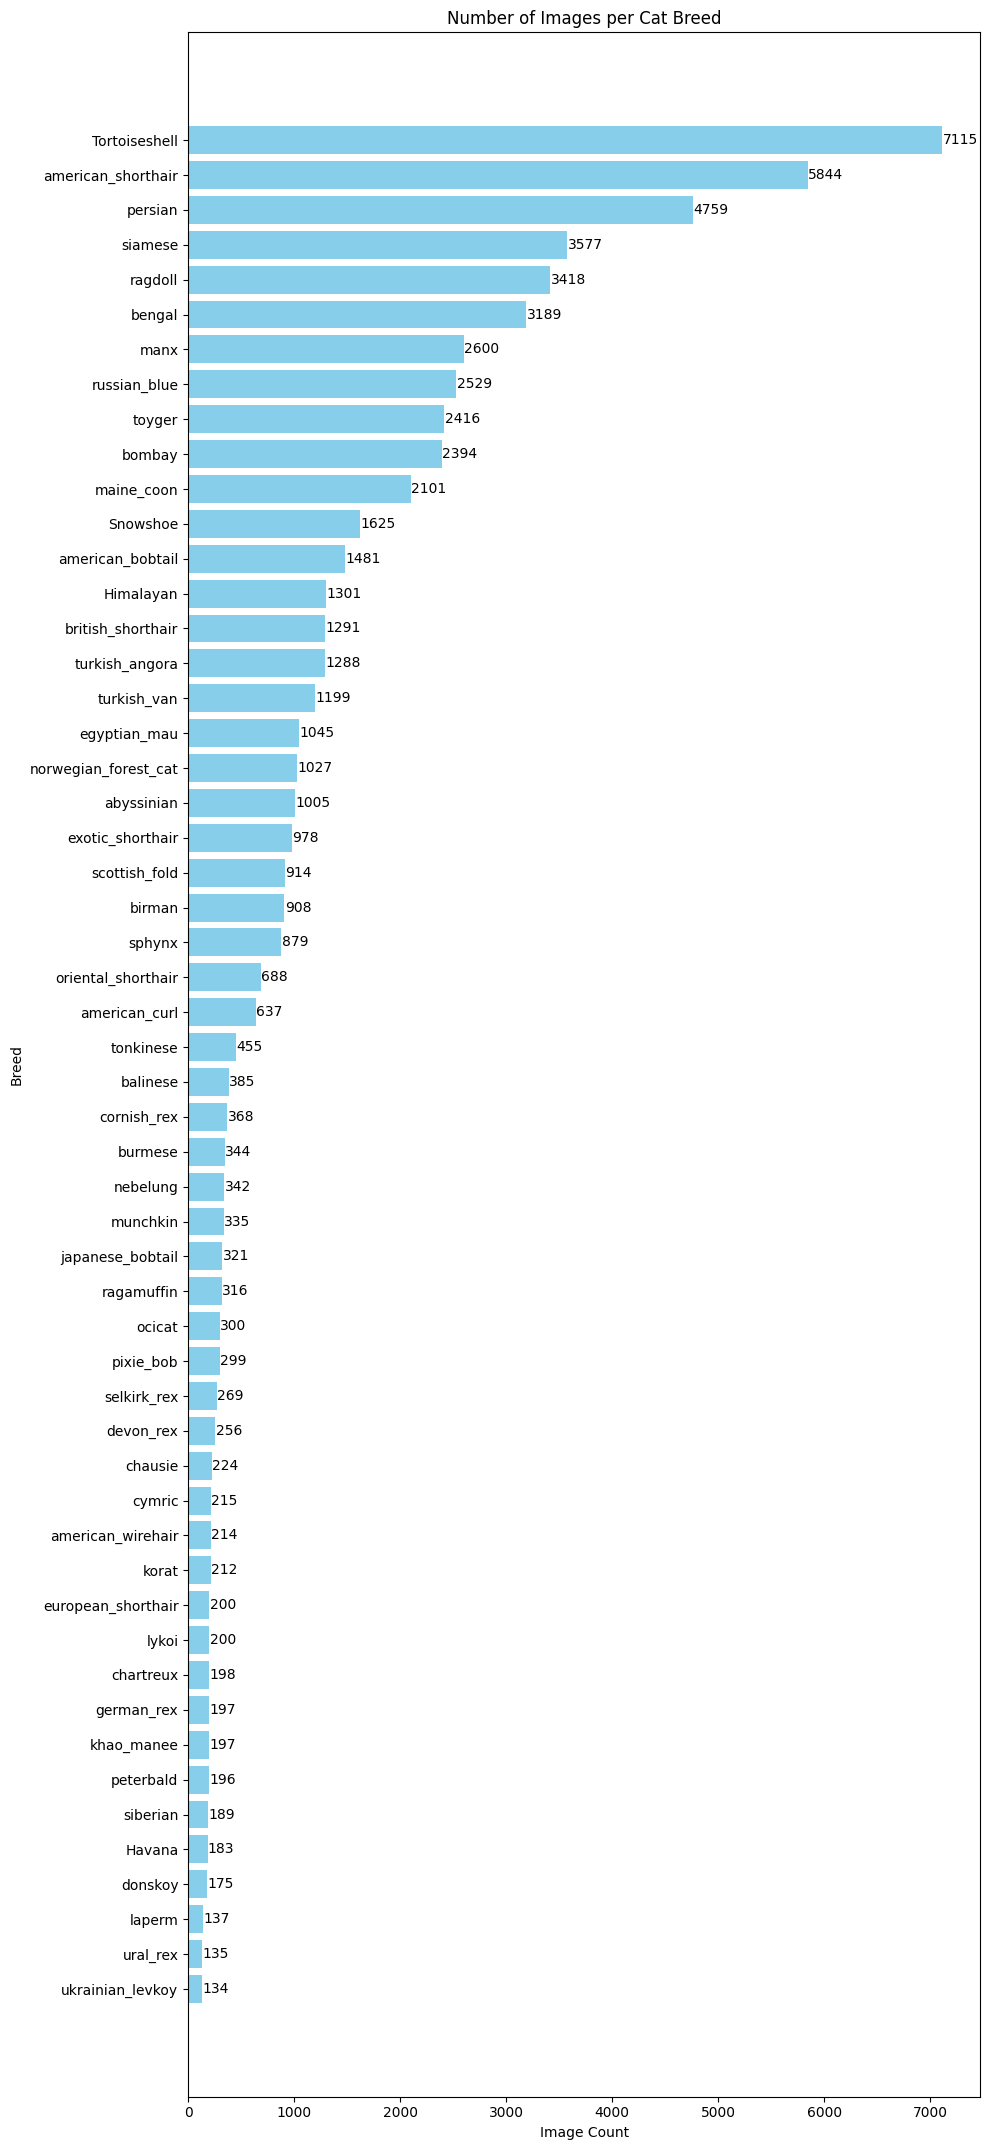

In [ ]:
plot_breed_distribution(cat_breed_data)

## Augmenting the Data

In [ ]:
def augment_minority_classes(dataset_dir, target_count=750, file_extensions=('.jpg', '.jpeg', '.png')):
    # Augmentation settings
    datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    for class_name in os.listdir(dataset_dir):
        class_path = os.path.join(dataset_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        # Count existing images
        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(file_extensions)]
        num_images = len(image_files)

        # Skip if already at or above target
        if num_images >= target_count:
            continue

        print(f"Augmenting class '{class_name}' from {num_images} to {target_count} images...")

        # Randomly sample images to augment
        needed = target_count - num_images
        augment_images = np.random.choice(image_files, size=needed, replace=True)

        # Generate and save augmented images
        for i, img_name in enumerate(tqdm(augment_images)):
            img_path = os.path.join(class_path, img_name)
            img = load_img(img_path)
            x = img_to_array(img)
            x = np.expand_dims(x, axis=0)

            # Generate a batch of 1 augmented image
            aug_iter = datagen.flow(x, batch_size=1)
            aug_img = next(aug_iter)[0].astype(np.uint8)

            # Save with new filename
            save_path = os.path.join(class_path, f"aug_{i}_{img_name}")
            array_to_img(aug_img).save(save_path)

    print("Augmentation complete.")

In [ ]:
# Commenting this out after running it once because it saves the images
#augment_minority_classes(cat_breed_data)

Augmenting class 'european_shorthair' from 200 to 750 images...


100%|██████████| 550/550 [00:11<00:00, 47.71it/s]


Augmenting class 'lykoi' from 200 to 750 images...


100%|██████████| 550/550 [00:13<00:00, 39.42it/s]


Augmenting class 'peterbald' from 196 to 750 images...


100%|██████████| 554/554 [00:14<00:00, 37.42it/s]


Augmenting class 'ukrainian_levkoy' from 134 to 750 images...


100%|██████████| 616/616 [00:10<00:00, 60.60it/s]


Augmenting class 'balinese' from 385 to 750 images...


100%|██████████| 365/365 [00:13<00:00, 27.75it/s]


Augmenting class 'donskoy' from 175 to 750 images...


100%|██████████| 575/575 [00:10<00:00, 53.98it/s]


Augmenting class 'ural_rex' from 135 to 750 images...


100%|██████████| 615/615 [00:11<00:00, 55.76it/s]


Augmenting class 'american_wirehair' from 214 to 750 images...


100%|██████████| 536/536 [00:10<00:00, 48.80it/s]


Augmenting class 'burmese' from 344 to 750 images...


100%|██████████| 406/406 [00:16<00:00, 24.07it/s]


Augmenting class 'chartreux' from 198 to 750 images...


100%|██████████| 552/552 [00:17<00:00, 31.84it/s]


Augmenting class 'chausie' from 224 to 750 images...


100%|██████████| 526/526 [00:12<00:00, 43.67it/s]


Augmenting class 'cornish_rex' from 368 to 750 images...


100%|██████████| 382/382 [00:13<00:00, 28.38it/s]


Augmenting class 'cymric' from 215 to 750 images...


100%|██████████| 535/535 [00:09<00:00, 53.79it/s]


Augmenting class 'devon_rex' from 256 to 750 images...


100%|██████████| 494/494 [00:14<00:00, 34.16it/s]


Augmenting class 'Havana' from 183 to 750 images...


100%|██████████| 567/567 [00:18<00:00, 30.15it/s]


Augmenting class 'japanese_bobtail' from 321 to 750 images...


100%|██████████| 429/429 [00:12<00:00, 33.85it/s]


Augmenting class 'korat' from 212 to 750 images...


100%|██████████| 538/538 [00:13<00:00, 40.89it/s]


Augmenting class 'laperm' from 137 to 750 images...


100%|██████████| 613/613 [00:12<00:00, 49.04it/s]


Augmenting class 'munchkin' from 335 to 750 images...


100%|██████████| 415/415 [00:13<00:00, 30.98it/s]


Augmenting class 'nebelung' from 342 to 750 images...


100%|██████████| 408/408 [00:12<00:00, 33.97it/s]


Augmenting class 'ocicat' from 300 to 750 images...


100%|██████████| 450/450 [00:12<00:00, 35.51it/s]


Augmenting class 'oriental_shorthair' from 688 to 750 images...


100%|██████████| 62/62 [00:18<00:00,  3.37it/s]


Augmenting class 'pixie_bob' from 299 to 750 images...


100%|██████████| 451/451 [00:12<00:00, 36.03it/s]


Augmenting class 'ragamuffin' from 316 to 750 images...


100%|██████████| 434/434 [00:13<00:00, 32.98it/s]


Augmenting class 'selkirk_rex' from 269 to 750 images...


100%|██████████| 481/481 [00:11<00:00, 40.10it/s]


Augmenting class 'siberian' from 189 to 750 images...


100%|██████████| 561/561 [00:19<00:00, 28.54it/s]


Augmenting class 'tonkinese' from 455 to 750 images...


100%|██████████| 295/295 [00:11<00:00, 24.63it/s]


Augmenting class 'american_curl' from 637 to 750 images...


100%|██████████| 113/113 [00:38<00:00,  2.94it/s]


Augmenting class 'german_rex' from 197 to 750 images...


100%|██████████| 553/553 [00:09<00:00, 55.45it/s]


Augmenting class 'khao_manee' from 197 to 750 images...


100%|██████████| 553/553 [00:09<00:00, 59.57it/s]


Augmentation complete.


Now lets verify that each class has at least 750 images

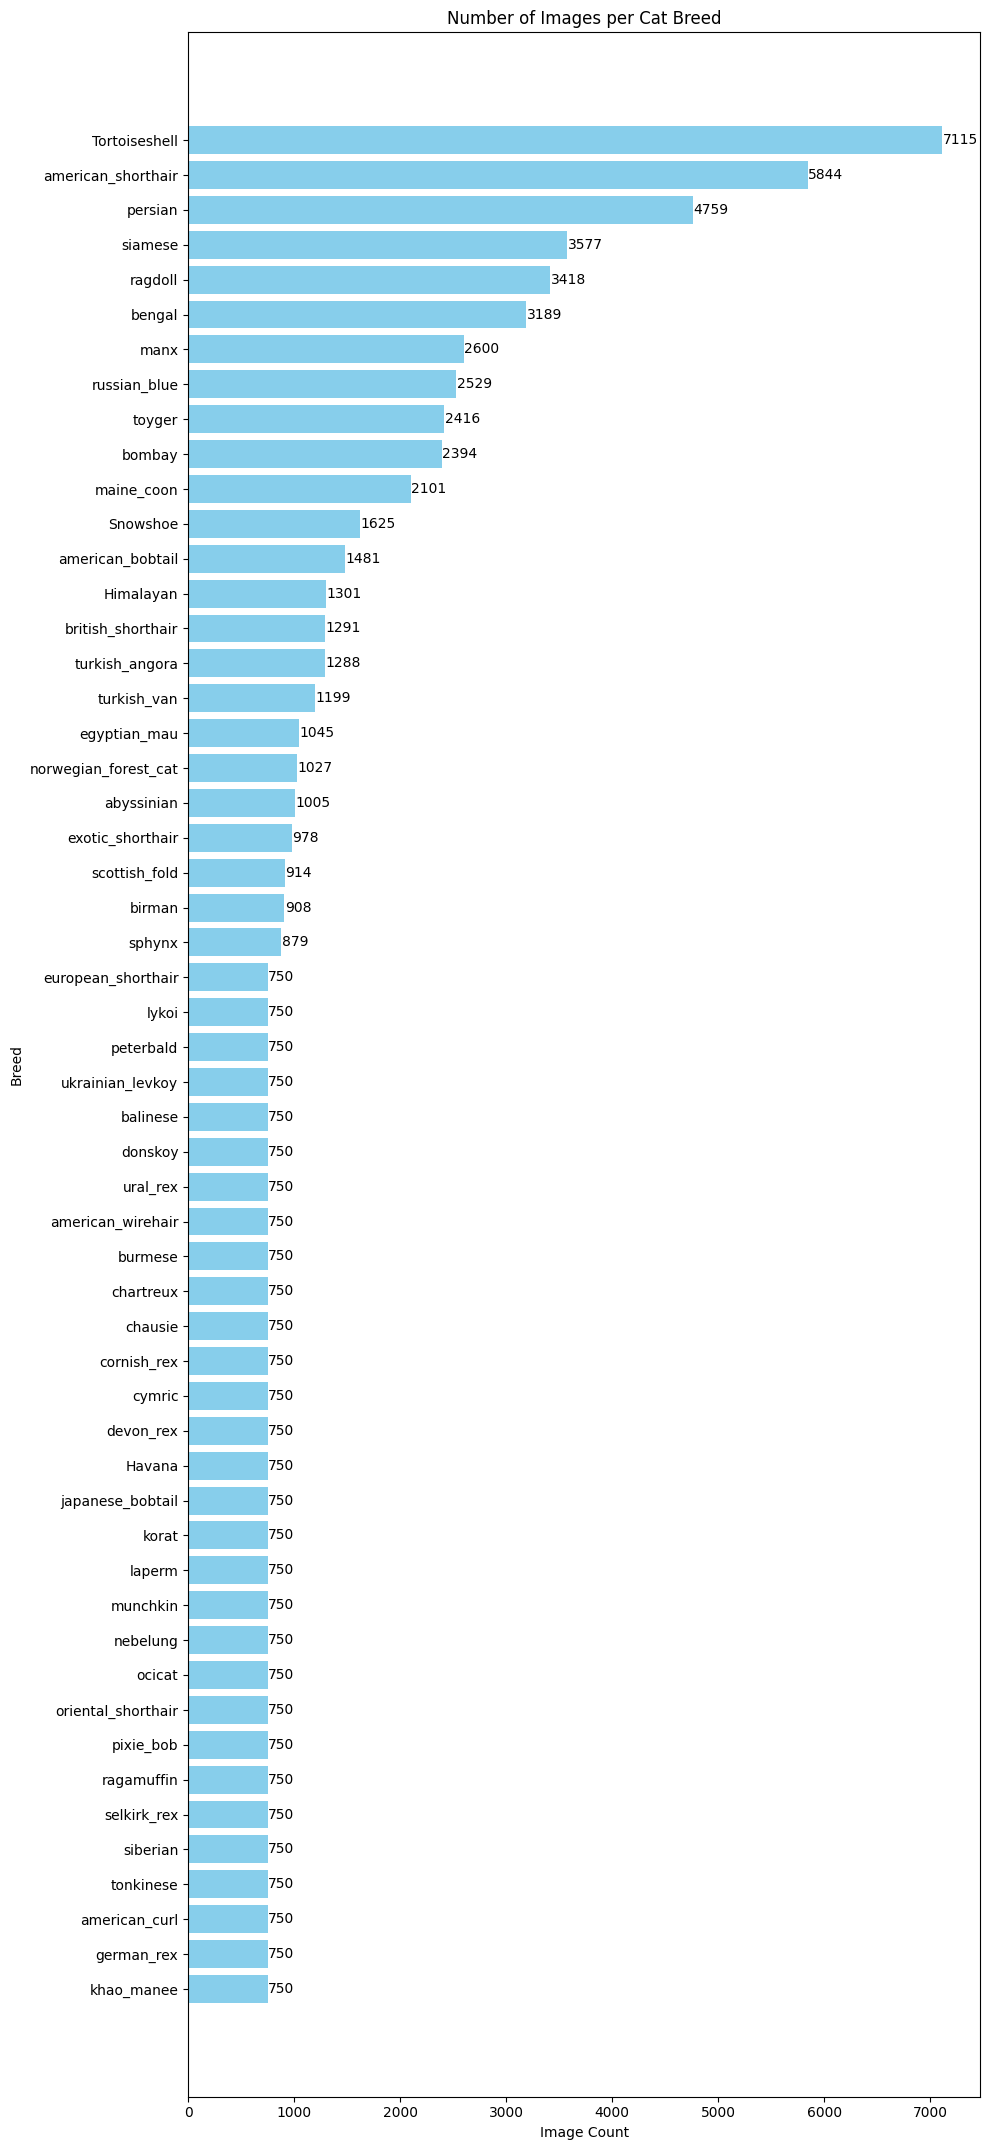

In [ ]:
plot_breed_distribution(cat_breed_data)

Great! Now I will reimport the data so the augmented images are included.

In [9]:
cat_breed_data = "/content/drive/MyDrive/Cat App/Model 2: Cat Breed/Data"

breed_train, breed_val = extract_breed_dataset(cat_breed_data)

Found 77383 files belonging to 54 classes.
Using 61907 files for training.
Found 77383 files belonging to 54 classes.
Using 15476 files for validation.


## Compiling and Training the Model

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

breed_train_pf = breed_train.prefetch(buffer_size=AUTOTUNE)
breed_val_pf = breed_val.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Set the number of breeds
num_classes = len(class_names)

# MobileNetV3 feature vector
mobilenet_url = "https://www.kaggle.com/models/google/mobilenet-v3/TensorFlow2/large-075-224-feature-vector/1"

# Build the model
mobilenet_layer = tf.keras.applications.MobileNetV3Large(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

mobilenet_layer.trainable = False


base_model_frozen = tf.keras.Sequential([
    mobilenet_layer,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
# Compile the model
base_model_frozen.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/Cat App/Model 2: Cat Breed/cat_breed_frozen.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    verbose=1
)

history_base_model_frozen = base_model_frozen.fit(
    breed_train_pf,
    validation_data = breed_val_pf,
    epochs = 5,
    callbacks = [early_stopping, model_checkpoint]
)

Epoch 1/5
1935/1935 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3267 - loss: 2.6081
Epoch 1: val_loss improved from inf to 1.75842, saving model to /content/drive/MyDrive/Cat App/Model 3: Cat Breed/cat_breed_frozen.weights.h5
1935/1935 ━━━━━━━━━━━━━━━━━━━━ 9907s 5s/step - accuracy: 0.3268 - loss: 2.6079 - val_accuracy: 0.5016 - val_loss: 1.7584
Epoch 2/5
1935/1935 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.4741 - loss: 1.8667
Epoch 2: val_loss improved from 1.75842 to 1.68227, saving model to /content/drive/MyDrive/Cat App/Model 3: Cat Breed/cat_breed_frozen.weights.h5
1935/1935 ━━━━━━━━━━━━━━━━━━━━ 313s 151ms/step - accuracy: 0.4741 - loss: 1.8667 - val_accuracy: 0.5229 - val_loss: 1.6823
Epoch 3/5
1935/1935 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.4989 - loss: 1.7882
Epoch 3: val_loss improved from 1.68227 to 1.66793, saving model to /content/drive/MyDrive/Cat App/Model 3: Cat Breed/cat_breed_frozen.weights.h5
1935/1935 ━━━━━━━━━━━━━━━━━━━━ 293s 151ms/step - accuracy:

## Unfreezing the Top 10 Layers

In [ ]:
class_names = breed_train.class_names

# Rebuild the same model architecture
num_classes = len(class_names)

# MobileNetV3 feature vector
mobilenet_url = "https://www.kaggle.com/models/google/mobilenet-v3/TensorFlow2/large-075-224-feature-vector/1"

# Build the model
mobilenet_layer = tf.keras.applications.MobileNetV3Large(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

mobilenet_layer.trainable = True

# Then freeze all but the top 15 layers
for layer in mobilenet_layer.layers[:-15]:
    layer.trainable = False

base_model_unfrozen = tf.keras.Sequential([
    mobilenet_layer,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

base_model_unfrozen = tf.keras.Sequential([
    mobilenet_layer,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Build the model with dummy data (required before loading weights)
base_model_unfrozen(tf.zeros([1, 224, 224, 3]))

# Load the saved weights
base_model_unfrozen.load_weights('/content/drive/MyDrive/Cat App/Model 2: Cat Breed/cat_breed_frozen.weights.h5')


In [ ]:
base_model_unfrozen.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

The model was trained locally due to the long training process. I will load the trained model and test it on some images to see what breeds are predicted

## Testing the Breed Classification Model

In [12]:
class_names = breed_train.class_names

# Rebuild the same model architecture
num_classes = len(class_names)

# MobileNetV3 feature vector
mobilenet_url = "https://www.kaggle.com/models/google/mobilenet-v3/TensorFlow2/large-075-224-feature-vector/1"

# Build the model
mobilenet_layer = tf.keras.applications.MobileNetV3Large(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

mobilenet_layer.trainable = True

# Then freeze all but the top 15 layers
for layer in mobilenet_layer.layers[:-15]:
    layer.trainable = False

base_model_unfrozen = tf.keras.Sequential([
    mobilenet_layer,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

base_model_unfrozen = tf.keras.Sequential([
    mobilenet_layer,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Build the model with dummy data (required before loading weights)
base_model_unfrozen(tf.zeros([1, 224, 224, 3]))

# Load the saved weights
base_model_unfrozen.load_weights('/content/drive/MyDrive/Cat App/Model 2: Cat Breed/cat_breed_unfrozen.weights.h5')

In [2]:
def predict_and_show(img_path, model, class_names, k=3):
    # Load + preprocess image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = tf.keras.applications.mobilenet_v3.preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    preds = model.predict(img_array)[0]  # shape: (num_classes,)
    top_k_indices = preds.argsort()[-k:][::-1]
    top_k_predictions = [(class_names[i], float(preds[i])) for i in top_k_indices]

    # Plot image
    plt.imshow(image.load_img(img_path))
    plt.axis("off")

    # Build label text
    label_text = "\n".join([f"{name}: {conf:.2%}" for name, conf in top_k_predictions])
    plt.title(label_text, fontsize=10)

    plt.show()

    return top_k_predictions


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


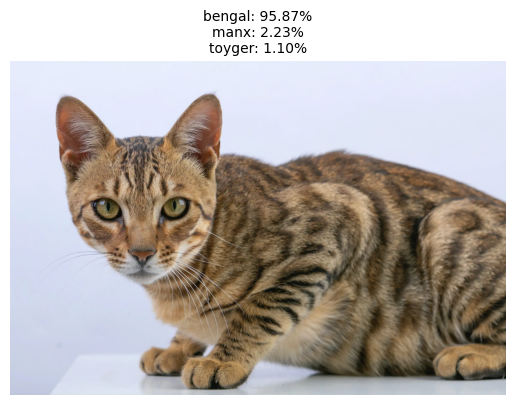

[('bengal', 0.9586648941040039),
 ('manx', 0.022338353097438812),
 ('toyger', 0.011049970984458923)]

In [14]:
bengal_test = "/content/drive/MyDrive/Cat App/Model 2: Cat Breed/Test Images/test-bengal.png"
bsh_test = "/content/drive/MyDrive/Cat App/Model 2: Cat Breed/Test Images/test-bsh.png"

predict_and_show(bengal_test, base_model_unfrozen, breed_train.class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


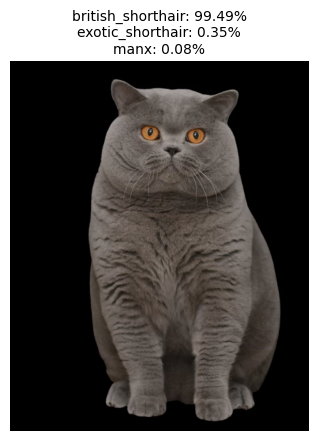

[('british_shorthair', 0.9948602318763733),
 ('exotic_shorthair', 0.003516031429171562),
 ('manx', 0.0007926317630335689)]

In [ ]:
predict_and_show(bsh_test, base_model_unfrozen, breed_train.class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


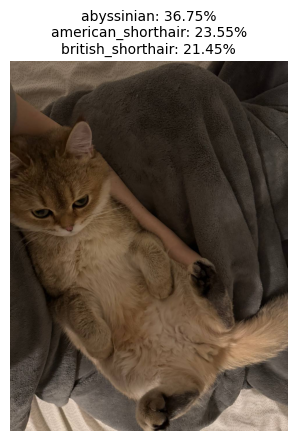

[('abyssinian', 0.3675326704978943),
 ('american_shorthair', 0.2354663461446762),
 ('british_shorthair', 0.21453596651554108)]

In [17]:
kiwi_test = "/content/drive/MyDrive/Cat App/Model 2: Cat Breed/Test Images/kiwi-test-2.jpg"
predict_and_show(kiwi_test, base_model_unfrozen, breed_train.class_names)

The model is working somewhat well with room for improvement! It seems to predict well with a clear head-on picture of the cat. The final image, my cat Kiwi, had him on his back. He is a British Shorthair, but the model was most confident about him being an Abyssinian. I believe predictions could be improved my including more training data of cats in more non-conventional or harder to see angles.

# Creating a Prediction Pipeline

In this final section of the notebook I will be creating a pipeline of all the models trained so far. The purpose of this is to allow for exporting the models for use outside of this notebook. As a reminder the path for prediction is the following:

Model 1: Classify if the image is of a cat or not. If not, exit here. If it is, crop the image and feed to the classification model

Model 2: Output top K predictions for the breed of the cat

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing import image
import tensorflow_hub as hub
import tf_keras
from tf_keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from ultralytics import YOLO

In [38]:
def final_cat_breed_predict_pipeline(img_path,
                                     YOlOv8_path,
                                     cat_breed_classifier_path,
                                     breed_class_names,
                                     k=3):
  # Load + preprocess image
  img = image.load_img(img_path, target_size=(224, 224))
  img_array = image.img_to_array(img)
  img_array = tf.keras.applications.mobilenet_v3.preprocess_input(img_array)
  img_array = np.expand_dims(img_array, axis=0)

  # Load in Yolo cropping model
  yolo_model = YOLO(YOlOv8_path)

  results = yolo_model(img_path)

  CAT_CLASS_ID = 15
  cropped_cats = []

  for result in results:
    boxes = result.boxes
    for box in boxes:
      cls_id = int(box.cls[0].item())
      if cls_id == CAT_CLASS_ID:
        x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
        orig_img = image.load_img(img_path)  # reload full res
        orig_arr = np.array(orig_img)
        cropped_cat = orig_arr[y1:y2, x1:x2]

        # Preprocess for breed model
        tf_cat = tf.convert_to_tensor(cropped_cat, dtype=tf.float32)
        tf_cat = tf.image.resize(tf_cat, (224, 224))
        tf_cat = tf.keras.applications.mobilenet_v3.preprocess_input(tf_cat)
        cropped_cats.append(tf.expand_dims(tf_cat, 0))

  if not cropped_cats:
    print("No cats detected by YOLO")
    return {"is_cat": False, "breed_predictions": None}

  # Load in breed model

  # Rebuild the same model architecture
  num_classes = len(class_names)

  # Build the model
  mobilenet_layer = tf.keras.applications.MobileNetV3Large(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
  )

  mobilenet_layer.trainable = True

  # Then freeze all but the top 15 layers
  for layer in mobilenet_layer.layers[:-15]:
    layer.trainable = False

  breed_model = tf.keras.Sequential([
    mobilenet_layer,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(num_classes, activation='softmax')
  ])

  breed_model = tf.keras.Sequential([
    mobilenet_layer,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(num_classes, activation='softmax')
  ])

  # Build the model with dummy data (required before loading weights)
  breed_model(tf.zeros([1, 224, 224, 3]))

  # Load the saved weights
  breed_model.load_weights(cat_breed_classifier_path)

  all_preds = []

  for crop in cropped_cats:
    preds = breed_model.predict(crop)[0]
    top_k_indices = preds.argsort()[-k:][::-1]
    top_k_predictions = [(breed_class_names[i], float(preds[i])) for i in top_k_indices]
    all_preds.append(top_k_predictions)

  return {"is_cat": True, "breed_predictions": all_preds}

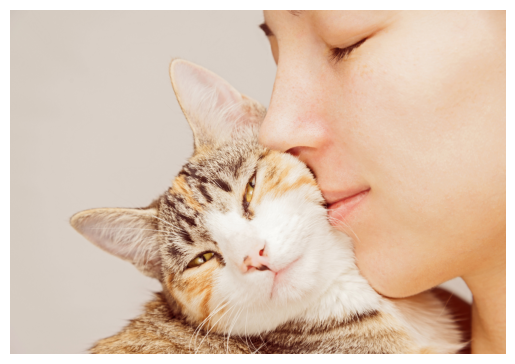


0: 448x640 1 cat, 28.6ms
Speed: 2.8ms preprocess, 28.6ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)


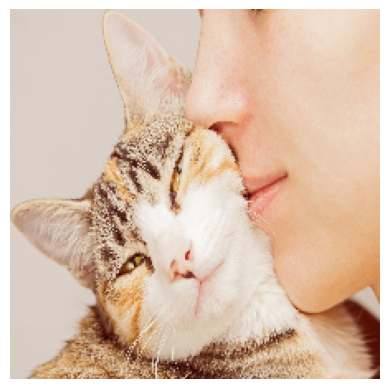


image 1/1 /content/drive/MyDrive/Cat App/Model 2: YOLOv8/cat and person.jpg: 448x640 1 person, 1 cat, 27.3ms
Speed: 2.4ms preprocess, 27.3ms inference, 6.8ms postprocess per image at shape (1, 3, 448, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


{'is_cat': True,
 'breed_predictions': [[('american_shorthair', 0.42897510528564453),
   ('toyger', 0.20340339839458466),
   ('egyptian_mau', 0.12401458621025085)]]}

In [35]:
test_img = "/content/drive/MyDrive/Cat App/Model 2: YOLOv8/cat and person.jpg"
yolo_model = YOLO('yolov8m.pt')
breed_classifier_model = "/content/drive/MyDrive/Cat App/Model 2: Cat Breed/cat_breed_unfrozen.weights.h5"

# to show the image being predicted
show_example_cropping(test_img, yolo_model)

final_cat_breed_predict_pipeline(test_img,
                                 yolo_model,
                                 breed_classifier_model,
                                 breed_train.class_names)

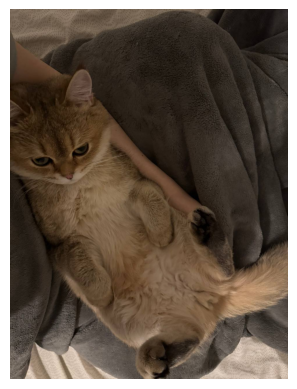


0: 640x480 1 cat, 1 dog, 30.8ms
Speed: 4.3ms preprocess, 30.8ms inference, 6.6ms postprocess per image at shape (1, 3, 640, 480)


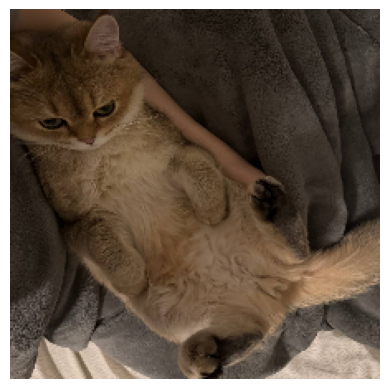


image 1/1 /content/drive/MyDrive/Cat App/Model 2: Cat Breed/Test Images/kiwi-test-2.jpg: 640x480 1 person, 1 cat, 1 dog, 32.9ms
Speed: 7.1ms preprocess, 32.9ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 480)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


{'is_cat': True,
 'breed_predictions': [[('british_shorthair', 0.2967929542064667),
   ('american_shorthair', 0.26702696084976196),
   ('abyssinian', 0.23956556618213654)]]}

In [37]:
show_example_cropping(kiwi_test, yolo_model)

final_cat_breed_predict_pipeline(kiwi_test,
                                 yolo_model,
                                 breed_classifier_model,
                                 breed_train.class_names)

I'm super happy the cropping made the prediction of Kiwi's breed better! It is now most confident that he is a British shorthair, which was not the case before the cropping from YOLOv8.

Lets try it on Squidward.

In [39]:
squidward_test = "/content/drive/MyDrive/Cat Breed Classification/Cat Images/squidward.jpg"


final_cat_breed_predict_pipeline(squidward_test,
                                 yolo_model,
                                 breed_classifier_model,
                                 breed_train.class_names)


image 1/1 /content/drive/MyDrive/Cat Breed Classification/Cat Images/squidward.jpg: 384x640 1 cake, 26.1ms
Speed: 2.5ms preprocess, 26.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)
No cats detected by YOLO


{'is_cat': False, 'breed_predictions': None}

## Conclusion

I am pretty happy with how this turned out! I have created a pipeline that can detect if a cat is in an image, crop the image if the cat is there, and then predict the cat's breed.

I have also saved the model and created a function that ties the models together. This could potentially be used by vets to help identify strays or by animal shelters when they are advertising a cat for adoption online and they are not sure of the breed.